Get the data:

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ptfrwrd","key":"bfab6acd202f40844c593a65cdc00470"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d  datatattle/covid-19-nlp-text-classification

100% 4.38M/4.38M [00:00<00:00, 11.9MB/s]



In [4]:
! unzip covid-19-nlp-text-classification.zip

Archive:  covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


# Load the data

In [5]:
! pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=c43be8f3f3a908d084eee17e3883fcf42c008d905dbf46d4651b3fd7d420595f
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [6]:
! pip install pyhanlp

     |████████████████████████████████| 136 kB 4.1 MB/s 
     |████████████████████████████████| 2.8 MB 19.2 MB/s 
  Created wheel for pyhanlp: filename=pyhanlp-0.1.79-py3-none-any.whl size=29803 sha256=7cb57de0cc4a93098c350b76ca895001dd01379408263653b9f8b38cb4ab7519
  Stored in directory: /root/.cache/pip/wheels/27/48/ad/61fea783778a3ea1bf4a62b7eab8f93842694cde7f9899e03b
  Created wheel for hanlp-downloader: filename=hanlp_downloader-0.0.25-py3-none-any.whl size=13776 sha256=c749aac899221ab59f94d0bf4b3c4db9c5699c8e1c5da40926803c0318ecaf3b
  Stored in directory: /root/.cache/pip/wheels/cb/a2/c3/61f7b80f5d56e5b19dd9cb50303f8f3b621662f035a281d197
Successfully built pyhanlp hanlp-downloader


In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import pandas as pd

In [10]:
train_data = pd.read_csv('Corona_NLP_train.csv', encoding="latin1")
train_data.sample(5)

UserName  ...  Sentiment
13818     17617  ...    Neutral
10201     14000  ...   Positive
17655     21454  ...   Negative
3595       7394  ...   Negative
28186     31985  ...    Neutral

[5 rows x 6 columns]

In [11]:
train_data.shape[0]

41157

In [12]:
test_data = pd.read_csv('/content/Corona_NLP_test.csv', encoding="latin1")
test_data.sample(5)

UserName  ...           Sentiment
1151      1152  ...            Negative
1873      1874  ...  Extremely Positive
557        558  ...            Negative
2730      2731  ...             Neutral
1026      1027  ...            Negative

[5 rows x 6 columns]

In [13]:
test_data.shape[0]

3798

In [14]:
train_data = pd.concat([train_data, test_data], axis=0)
train_data.sample(2)

UserName  ...  Sentiment
31340     35139  ...   Positive
40708     44507  ...   Positive

[2 rows x 6 columns]

In [15]:
train_data.shape[0]

44955

# Get model

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
%cd /content/gdrive/MyDrive/topic_modleing/Neural_Topic_Models

/content/gdrive/MyDrive/topic_modleing/Neural_Topic_Models


In [30]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [34]:
import sys
sys.path.append('/content/gdrive/MyDrive/topic_modleing/Neural_Topic_Models/src')

import os
import re
import torch
import pickle
import argparse
import logging
import time
from BATM import BATM
from utils import *
from dataset import DocDataset, TestData
from multiprocessing import cpu_count

下载 https://file.hankcs.com/hanlp/hanlp-1.8.2-release.zip 到 /usr/local/lib/python3.7/dist-packages/pyhanlp/static/hanlp-1.8.2-release.zip
100%   1.8 MiB 156.9 KiB/s ETA:  0 s [=========================================]
下载 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 到 /usr/local/lib/python3.7/dist-packages/pyhanlp/static/data-for-1.8.2.zip
100% 637.7 MiB   8.3 MiB/s ETA:  0 s [=========================================]


解压 data.zip...


In [35]:
taskname = 'covid'
no_below = 5
no_above = .03
num_epochs = 200
n_topic = 15
n_cpu = cpu_count()-2 if cpu_count()>2 else 2
use_tfidf = True
rebuild = True

device = torch.device('cuda')

In [36]:
docSet = DocDataset(df=train_data,
                    column_with_text='OriginalTweet',
                    taskname=taskname,
                    lang='en',
                    no_below=no_below,
                    no_above=no_above,
                    rebuild=rebuild,
                    use_tfidf=use_tfidf)

Tokenizing ...
Tokenization ...
Processed 44874 documents.


In [37]:
auto_adj = False

if auto_adj:
  no_above = docSet.topk_dfs(topk=20)
  docSet = DocDataset(taskname=taskname,lang=lang,no_below=no_below,no_above=no_above,rebuild=rebuild,use_tfidf=False)
voc_size = docSet.vocabsize
print(voc_size )

9928


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch   1	Iter    1	Loss_D:-0.0820381	Loss_G:0.0023114	loss_E:-0.0009877
Epoch   1	Iter   11	Loss_D:-0.0016742	Loss_G:0.0037820	loss_E:-0.0018603
Epoch   1	Iter   21	Loss_D:-0.0025207	Loss_G:0.0044744	loss_E:-0.0016632
Epoch   1	Iter   31	Loss_D:-0.0035538	Loss_G:0.0047375	loss_E:-0.0008868
Epoch   1	Iter   41	Loss_D:-0.0045753	Loss_G:0.0043783	loss_E:0.0004482
Epoch   1	Iter   51	Loss_D:-0.0052644	Loss_G:0.0036167	loss_E:0.0018488
Epoch   1	Iter   61	Loss_D:-0.0055075	Loss_G:0.0031651	loss_E:0.0025338
Epoch   1	Iter   71	Loss_D:-0.0057771	Loss_G:0.0030258	loss_E:0.0029420
Epoch   1	Iter   81	Loss_D:-0.0058858	Loss_G:0.0029708	loss_E:0.0031119
Epoch   2	Iter    1	Loss_D:-0.0064081	Loss_G:0.0030230	loss_E:0.0035759
Epoch   2	Iter   11	Loss_D:-0.0064139	Loss_G:0.0030030	loss_E:0.0036162
Epoch   2	Iter   21	Loss_D:-0.0067070	Loss_G:0.0030578	loss_E:0.0038597
Epoch   2	Iter   31	Loss_D:-0.0069356	Loss_G:0.0032416	loss_E:0.0039302
Epoch   2	Iter   41	Loss_D:-0.0066976	Loss_G:0.0030551	loss_

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  11	Iter    1	Loss_D:-0.0200828	Loss_G:0.0131152	loss_E:0.0074268
Epoch  11	Iter   11	Loss_D:-0.0204976	Loss_G:0.0133859	loss_E:0.0075921
Epoch  11	Iter   21	Loss_D:-0.0207662	Loss_G:0.0139227	loss_E:0.0073204
Epoch  11	Iter   31	Loss_D:-0.0204950	Loss_G:0.0138400	loss_E:0.0071417
Epoch  11	Iter   41	Loss_D:-0.0206311	Loss_G:0.0141917	loss_E:0.0069209
Epoch  11	Iter   51	Loss_D:-0.0208157	Loss_G:0.0145331	loss_E:0.0067741
Epoch  11	Iter   61	Loss_D:-0.0207557	Loss_G:0.0146082	loss_E:0.0066481
Epoch  11	Iter   71	Loss_D:-0.0209993	Loss_G:0.0152655	loss_E:0.0062162
Epoch  11	Iter   81	Loss_D:-0.0213616	Loss_G:0.0155492	loss_E:0.0063243
Epoch  12	Iter    1	Loss_D:-0.0217830	Loss_G:0.0157022	loss_E:0.0065650
Epoch  12	Iter   11	Loss_D:-0.0213801	Loss_G:0.0153073	loss_E:0.0065627
Epoch  12	Iter   21	Loss_D:-0.0215874	Loss_G:0.0158035	loss_E:0.0062689
Epoch  12	Iter   31	Loss_D:-0.0213638	Loss_G:0.0156912	loss_E:0.0061574
Epoch  12	Iter   41	Loss_D:-0.0213502	Loss_G:0.0159698	loss_E:0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  21	Iter    1	Loss_D:-0.0184670	Loss_G:0.0171994	loss_E:0.0016814
Epoch  21	Iter   11	Loss_D:-0.0178528	Loss_G:0.0166678	loss_E:0.0015839
Epoch  21	Iter   21	Loss_D:-0.0181349	Loss_G:0.0167698	loss_E:0.0017531
Epoch  21	Iter   31	Loss_D:-0.0182552	Loss_G:0.0169256	loss_E:0.0017451
Epoch  21	Iter   41	Loss_D:-0.0177916	Loss_G:0.0168306	loss_E:0.0013542
Epoch  21	Iter   51	Loss_D:-0.0174067	Loss_G:0.0164542	loss_E:0.0013434
Epoch  21	Iter   61	Loss_D:-0.0174340	Loss_G:0.0165601	loss_E:0.0012779
Epoch  21	Iter   71	Loss_D:-0.0177496	Loss_G:0.0168330	loss_E:0.0013245
Epoch  21	Iter   81	Loss_D:-0.0172056	Loss_G:0.0165214	loss_E:0.0010869
Epoch  22	Iter    1	Loss_D:-0.0176969	Loss_G:0.0167183	loss_E:0.0013745
Epoch  22	Iter   11	Loss_D:-0.0176983	Loss_G:0.0168767	loss_E:0.0012107
Epoch  22	Iter   21	Loss_D:-0.0172595	Loss_G:0.0163371	loss_E:0.0013277
Epoch  22	Iter   31	Loss_D:-0.0174784	Loss_G:0.0165965	loss_E:0.0012960
Epoch  22	Iter   41	Loss_D:-0.0173019	Loss_G:0.0163669	loss_E:0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  31	Iter    1	Loss_D:-0.0171484	Loss_G:0.0163220	loss_E:0.0012217
Epoch  31	Iter   11	Loss_D:-0.0172073	Loss_G:0.0162469	loss_E:0.0013526
Epoch  31	Iter   21	Loss_D:-0.0167355	Loss_G:0.0163142	loss_E:0.0007968
Epoch  31	Iter   31	Loss_D:-0.0168058	Loss_G:0.0161660	loss_E:0.0010313
Epoch  31	Iter   41	Loss_D:-0.0171177	Loss_G:0.0161780	loss_E:0.0013585
Epoch  31	Iter   51	Loss_D:-0.0169990	Loss_G:0.0161893	loss_E:0.0012056
Epoch  31	Iter   61	Loss_D:-0.0168548	Loss_G:0.0162511	loss_E:0.0009952
Epoch  31	Iter   71	Loss_D:-0.0168704	Loss_G:0.0163048	loss_E:0.0009467
Epoch  31	Iter   81	Loss_D:-0.0167497	Loss_G:0.0163330	loss_E:0.0007998
Epoch  32	Iter    1	Loss_D:-0.0167988	Loss_G:0.0162321	loss_E:0.0009443
Epoch  32	Iter   11	Loss_D:-0.0165397	Loss_G:0.0159751	loss_E:0.0009443
Epoch  32	Iter   21	Loss_D:-0.0168288	Loss_G:0.0161742	loss_E:0.0010375
Epoch  32	Iter   31	Loss_D:-0.0168397	Loss_G:0.0162029	loss_E:0.0010228
Epoch  32	Iter   41	Loss_D:-0.0169367	Loss_G:0.0161601	loss_E:0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  41	Iter    1	Loss_D:-0.0168297	Loss_G:0.0157443	loss_E:0.0014671
Epoch  41	Iter   11	Loss_D:-0.0167062	Loss_G:0.0157729	loss_E:0.0012891
Epoch  41	Iter   21	Loss_D:-0.0167806	Loss_G:0.0157346	loss_E:0.0014140
Epoch  41	Iter   31	Loss_D:-0.0167024	Loss_G:0.0158761	loss_E:0.0011962
Epoch  41	Iter   41	Loss_D:-0.0161771	Loss_G:0.0156358	loss_E:0.0008984
Epoch  41	Iter   51	Loss_D:-0.0165197	Loss_G:0.0157755	loss_E:0.0011159
Epoch  41	Iter   61	Loss_D:-0.0163875	Loss_G:0.0156214	loss_E:0.0011568
Epoch  41	Iter   71	Loss_D:-0.0162871	Loss_G:0.0157031	loss_E:0.0009646
Epoch  41	Iter   81	Loss_D:-0.0165101	Loss_G:0.0156684	loss_E:0.0012084
Epoch  42	Iter    1	Loss_D:-0.0165410	Loss_G:0.0158565	loss_E:0.0010514
Epoch  42	Iter   11	Loss_D:-0.0168425	Loss_G:0.0157447	loss_E:0.0014764
Epoch  42	Iter   21	Loss_D:-0.0166074	Loss_G:0.0155519	loss_E:0.0014419
Epoch  42	Iter   31	Loss_D:-0.0167358	Loss_G:0.0155889	loss_E:0.0015368
Epoch  42	Iter   41	Loss_D:-0.0167655	Loss_G:0.0158796	loss_E:0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  51	Iter    1	Loss_D:-0.0164190	Loss_G:0.0158523	loss_E:0.0009272
Epoch  51	Iter   11	Loss_D:-0.0167350	Loss_G:0.0160481	loss_E:0.0010705
Epoch  51	Iter   21	Loss_D:-0.0163110	Loss_G:0.0158532	loss_E:0.0008150
Epoch  51	Iter   31	Loss_D:-0.0162926	Loss_G:0.0160504	loss_E:0.0006030
Epoch  51	Iter   41	Loss_D:-0.0160619	Loss_G:0.0157551	loss_E:0.0006627
Epoch  51	Iter   51	Loss_D:-0.0160161	Loss_G:0.0156523	loss_E:0.0007363
Epoch  51	Iter   61	Loss_D:-0.0161287	Loss_G:0.0161021	loss_E:0.0003812
Epoch  51	Iter   71	Loss_D:-0.0161331	Loss_G:0.0159170	loss_E:0.0005880
Epoch  51	Iter   81	Loss_D:-0.0160754	Loss_G:0.0161057	loss_E:0.0003416
Epoch  52	Iter    1	Loss_D:-0.0163769	Loss_G:0.0159720	loss_E:0.0007676
Epoch  52	Iter   11	Loss_D:-0.0160876	Loss_G:0.0156253	loss_E:0.0008286
Epoch  52	Iter   21	Loss_D:-0.0160197	Loss_G:0.0157454	loss_E:0.0006363
Epoch  52	Iter   31	Loss_D:-0.0161555	Loss_G:0.0158990	loss_E:0.0006087
Epoch  52	Iter   41	Loss_D:-0.0161601	Loss_G:0.0158187	loss_E:0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  61	Iter    1	Loss_D:-0.0164323	Loss_G:0.0161390	loss_E:0.0006712
Epoch  61	Iter   11	Loss_D:-0.0160358	Loss_G:0.0161747	loss_E:0.0002129
Epoch  61	Iter   21	Loss_D:-0.0153870	Loss_G:0.0159016	loss_E:-0.0001563
Epoch  61	Iter   31	Loss_D:-0.0159781	Loss_G:0.0161458	loss_E:0.0001950
Epoch  61	Iter   41	Loss_D:-0.0157599	Loss_G:0.0158523	loss_E:0.0002823
Epoch  61	Iter   51	Loss_D:-0.0161373	Loss_G:0.0162419	loss_E:0.0002659
Epoch  61	Iter   61	Loss_D:-0.0154886	Loss_G:0.0159077	loss_E:-0.0000602
Epoch  61	Iter   71	Loss_D:-0.0158174	Loss_G:0.0162210	loss_E:-0.0000244
Epoch  61	Iter   81	Loss_D:-0.0155372	Loss_G:0.0158471	loss_E:0.0000749
Epoch  62	Iter    1	Loss_D:-0.0161591	Loss_G:0.0163437	loss_E:0.0001863
Epoch  62	Iter   11	Loss_D:-0.0160658	Loss_G:0.0161569	loss_E:0.0002692
Epoch  62	Iter   21	Loss_D:-0.0156999	Loss_G:0.0158196	loss_E:0.0002505
Epoch  62	Iter   31	Loss_D:-0.0156682	Loss_G:0.0161092	loss_E:-0.0000746
Epoch  62	Iter   41	Loss_D:-0.0159220	Loss_G:0.0163344	loss_

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  71	Iter    1	Loss_D:-0.0157097	Loss_G:0.0166550	loss_E:-0.0005961
Epoch  71	Iter   11	Loss_D:-0.0157045	Loss_G:0.0164293	loss_E:-0.0003784
Epoch  71	Iter   21	Loss_D:-0.0158592	Loss_G:0.0165502	loss_E:-0.0003277
Epoch  71	Iter   31	Loss_D:-0.0158352	Loss_G:0.0164523	loss_E:-0.0002510
Epoch  71	Iter   41	Loss_D:-0.0157294	Loss_G:0.0165105	loss_E:-0.0004283
Epoch  71	Iter   51	Loss_D:-0.0154522	Loss_G:0.0163663	loss_E:-0.0005595
Epoch  71	Iter   61	Loss_D:-0.0154521	Loss_G:0.0163859	loss_E:-0.0005617
Epoch  71	Iter   71	Loss_D:-0.0155279	Loss_G:0.0164575	loss_E:-0.0005441
Epoch  71	Iter   81	Loss_D:-0.0154289	Loss_G:0.0164939	loss_E:-0.0007064
Epoch  72	Iter    1	Loss_D:-0.0159271	Loss_G:0.0168104	loss_E:-0.0005210
Epoch  72	Iter   11	Loss_D:-0.0156755	Loss_G:0.0162769	loss_E:-0.0002424
Epoch  72	Iter   21	Loss_D:-0.0151458	Loss_G:0.0162755	loss_E:-0.0007796
Epoch  72	Iter   31	Loss_D:-0.0151618	Loss_G:0.0163123	loss_E:-0.0007971
Epoch  72	Iter   41	Loss_D:-0.0153440	Loss_G:0.0163

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  81	Iter    1	Loss_D:-0.0156506	Loss_G:0.0169862	loss_E:-0.0009826
Epoch  81	Iter   11	Loss_D:-0.0154481	Loss_G:0.0171301	loss_E:-0.0013467
Epoch  81	Iter   21	Loss_D:-0.0153373	Loss_G:0.0168960	loss_E:-0.0012181
Epoch  81	Iter   31	Loss_D:-0.0156372	Loss_G:0.0169866	loss_E:-0.0010120
Epoch  81	Iter   41	Loss_D:-0.0152429	Loss_G:0.0169986	loss_E:-0.0014050
Epoch  81	Iter   51	Loss_D:-0.0156144	Loss_G:0.0172037	loss_E:-0.0012577
Epoch  81	Iter   61	Loss_D:-0.0155130	Loss_G:0.0171803	loss_E:-0.0013304
Epoch  81	Iter   71	Loss_D:-0.0155141	Loss_G:0.0171542	loss_E:-0.0012971
Epoch  81	Iter   81	Loss_D:-0.0150481	Loss_G:0.0168743	loss_E:-0.0014908
Epoch  82	Iter    1	Loss_D:-0.0156738	Loss_G:0.0170532	loss_E:-0.0010251
Epoch  82	Iter   11	Loss_D:-0.0153458	Loss_G:0.0167708	loss_E:-0.0010919
Epoch  82	Iter   21	Loss_D:-0.0155026	Loss_G:0.0169661	loss_E:-0.0011087
Epoch  82	Iter   31	Loss_D:-0.0150934	Loss_G:0.0167512	loss_E:-0.0013158
Epoch  82	Iter   41	Loss_D:-0.0156285	Loss_G:0.0171

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  91	Iter    1	Loss_D:-0.0152603	Loss_G:0.0172257	loss_E:-0.0016294
Epoch  91	Iter   11	Loss_D:-0.0153106	Loss_G:0.0173042	loss_E:-0.0016543
Epoch  91	Iter   21	Loss_D:-0.0152995	Loss_G:0.0174076	loss_E:-0.0017798
Epoch  91	Iter   31	Loss_D:-0.0150633	Loss_G:0.0172091	loss_E:-0.0018207
Epoch  91	Iter   41	Loss_D:-0.0154279	Loss_G:0.0173869	loss_E:-0.0016294
Epoch  91	Iter   51	Loss_D:-0.0154234	Loss_G:0.0174363	loss_E:-0.0016732
Epoch  91	Iter   61	Loss_D:-0.0147876	Loss_G:0.0172170	loss_E:-0.0020988
Epoch  91	Iter   71	Loss_D:-0.0152654	Loss_G:0.0172421	loss_E:-0.0016357
Epoch  91	Iter   81	Loss_D:-0.0150163	Loss_G:0.0172494	loss_E:-0.0018946
Epoch  92	Iter    1	Loss_D:-0.0151097	Loss_G:0.0172331	loss_E:-0.0017895
Epoch  92	Iter   11	Loss_D:-0.0153235	Loss_G:0.0172723	loss_E:-0.0016259
Epoch  92	Iter   21	Loss_D:-0.0152769	Loss_G:0.0173176	loss_E:-0.0017271
Epoch  92	Iter   31	Loss_D:-0.0154802	Loss_G:0.0173909	loss_E:-0.0015649
Epoch  92	Iter   41	Loss_D:-0.0152702	Loss_G:0.0174

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 101	Iter    1	Loss_D:-0.0151305	Loss_G:0.0175914	loss_E:-0.0021349
Epoch 101	Iter   11	Loss_D:-0.0152601	Loss_G:0.0177186	loss_E:-0.0021547
Epoch 101	Iter   21	Loss_D:-0.0153500	Loss_G:0.0179083	loss_E:-0.0022374
Epoch 101	Iter   31	Loss_D:-0.0152862	Loss_G:0.0177736	loss_E:-0.0021721
Epoch 101	Iter   41	Loss_D:-0.0154626	Loss_G:0.0179633	loss_E:-0.0021886
Epoch 101	Iter   51	Loss_D:-0.0152990	Loss_G:0.0179317	loss_E:-0.0023054
Epoch 101	Iter   61	Loss_D:-0.0152290	Loss_G:0.0179143	loss_E:-0.0023647
Epoch 101	Iter   71	Loss_D:-0.0153488	Loss_G:0.0180569	loss_E:-0.0023885
Epoch 101	Iter   81	Loss_D:-0.0152660	Loss_G:0.0179953	loss_E:-0.0024020
Epoch 102	Iter    1	Loss_D:-0.0155435	Loss_G:0.0180105	loss_E:-0.0021447
Epoch 102	Iter   11	Loss_D:-0.0155044	Loss_G:0.0179432	loss_E:-0.0021292
Epoch 102	Iter   21	Loss_D:-0.0156069	Loss_G:0.0178625	loss_E:-0.0019355
Epoch 102	Iter   31	Loss_D:-0.0151784	Loss_G:0.0178564	loss_E:-0.0023657
Epoch 102	Iter   41	Loss_D:-0.0149952	Loss_G:0.0178

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 111	Iter    1	Loss_D:-0.0156660	Loss_G:0.0183806	loss_E:-0.0024163
Epoch 111	Iter   11	Loss_D:-0.0155467	Loss_G:0.0184302	loss_E:-0.0025821
Epoch 111	Iter   21	Loss_D:-0.0152625	Loss_G:0.0181729	loss_E:-0.0025923
Epoch 111	Iter   31	Loss_D:-0.0152571	Loss_G:0.0183056	loss_E:-0.0027429
Epoch 111	Iter   41	Loss_D:-0.0152471	Loss_G:0.0182363	loss_E:-0.0026798
Epoch 111	Iter   51	Loss_D:-0.0152953	Loss_G:0.0182841	loss_E:-0.0026868
Epoch 111	Iter   61	Loss_D:-0.0151016	Loss_G:0.0183454	loss_E:-0.0029467
Epoch 111	Iter   71	Loss_D:-0.0152010	Loss_G:0.0182993	loss_E:-0.0027737
Epoch 111	Iter   81	Loss_D:-0.0153001	Loss_G:0.0182998	loss_E:-0.0026856
Epoch 112	Iter    1	Loss_D:-0.0151708	Loss_G:0.0184258	loss_E:-0.0029524
Epoch 112	Iter   11	Loss_D:-0.0152714	Loss_G:0.0181180	loss_E:-0.0025492
Epoch 112	Iter   21	Loss_D:-0.0155480	Loss_G:0.0185372	loss_E:-0.0026800
Epoch 112	Iter   31	Loss_D:-0.0152105	Loss_G:0.0181675	loss_E:-0.0026576
Epoch 112	Iter   41	Loss_D:-0.0154771	Loss_G:0.0180

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 121	Iter    1	Loss_D:-0.0152525	Loss_G:0.0185272	loss_E:-0.0029820
Epoch 121	Iter   11	Loss_D:-0.0154988	Loss_G:0.0183681	loss_E:-0.0025730
Epoch 121	Iter   21	Loss_D:-0.0153549	Loss_G:0.0186009	loss_E:-0.0029488
Epoch 121	Iter   31	Loss_D:-0.0151838	Loss_G:0.0183506	loss_E:-0.0028685
Epoch 121	Iter   41	Loss_D:-0.0152961	Loss_G:0.0184846	loss_E:-0.0028676
Epoch 121	Iter   51	Loss_D:-0.0153519	Loss_G:0.0184905	loss_E:-0.0028230
Epoch 121	Iter   61	Loss_D:-0.0151092	Loss_G:0.0185065	loss_E:-0.0030909
Epoch 121	Iter   71	Loss_D:-0.0153541	Loss_G:0.0186129	loss_E:-0.0029654
Epoch 121	Iter   81	Loss_D:-0.0155016	Loss_G:0.0187931	loss_E:-0.0029788
Epoch 122	Iter    1	Loss_D:-0.0155177	Loss_G:0.0186003	loss_E:-0.0027799
Epoch 122	Iter   11	Loss_D:-0.0151979	Loss_G:0.0183725	loss_E:-0.0028849
Epoch 122	Iter   21	Loss_D:-0.0154329	Loss_G:0.0185308	loss_E:-0.0028041
Epoch 122	Iter   31	Loss_D:-0.0155484	Loss_G:0.0184838	loss_E:-0.0026363
Epoch 122	Iter   41	Loss_D:-0.0152729	Loss_G:0.0185

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 131	Iter    1	Loss_D:-0.0154823	Loss_G:0.0185616	loss_E:-0.0027809
Epoch 131	Iter   11	Loss_D:-0.0153118	Loss_G:0.0186553	loss_E:-0.0030566
Epoch 131	Iter   21	Loss_D:-0.0151895	Loss_G:0.0186140	loss_E:-0.0031297
Epoch 131	Iter   31	Loss_D:-0.0151583	Loss_G:0.0187373	loss_E:-0.0032737
Epoch 131	Iter   41	Loss_D:-0.0152210	Loss_G:0.0187345	loss_E:-0.0032051
Epoch 131	Iter   51	Loss_D:-0.0154527	Loss_G:0.0188697	loss_E:-0.0031139
Epoch 131	Iter   61	Loss_D:-0.0151877	Loss_G:0.0187599	loss_E:-0.0032641
Epoch 131	Iter   71	Loss_D:-0.0150606	Loss_G:0.0188488	loss_E:-0.0034932
Epoch 131	Iter   81	Loss_D:-0.0151098	Loss_G:0.0188799	loss_E:-0.0034724
Epoch 132	Iter    1	Loss_D:-0.0155134	Loss_G:0.0189723	loss_E:-0.0031386
Epoch 132	Iter   11	Loss_D:-0.0156572	Loss_G:0.0189391	loss_E:-0.0029942
Epoch 132	Iter   21	Loss_D:-0.0153889	Loss_G:0.0189070	loss_E:-0.0032175
Epoch 132	Iter   31	Loss_D:-0.0153689	Loss_G:0.0187880	loss_E:-0.0031329
Epoch 132	Iter   41	Loss_D:-0.0151009	Loss_G:0.0186

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 141	Iter    1	Loss_D:-0.0155161	Loss_G:0.0189933	loss_E:-0.0031698
Epoch 141	Iter   11	Loss_D:-0.0154310	Loss_G:0.0190119	loss_E:-0.0032845
Epoch 141	Iter   21	Loss_D:-0.0153939	Loss_G:0.0188958	loss_E:-0.0031998
Epoch 141	Iter   31	Loss_D:-0.0152741	Loss_G:0.0190467	loss_E:-0.0034836
Epoch 141	Iter   41	Loss_D:-0.0151602	Loss_G:0.0189955	loss_E:-0.0035500
Epoch 141	Iter   51	Loss_D:-0.0151936	Loss_G:0.0190379	loss_E:-0.0035459
Epoch 141	Iter   61	Loss_D:-0.0154587	Loss_G:0.0190983	loss_E:-0.0033466
Epoch 141	Iter   71	Loss_D:-0.0151425	Loss_G:0.0191613	loss_E:-0.0037322
Epoch 141	Iter   81	Loss_D:-0.0148222	Loss_G:0.0188223	loss_E:-0.0037001
Epoch 142	Iter    1	Loss_D:-0.0151346	Loss_G:0.0190740	loss_E:-0.0036519
Epoch 142	Iter   11	Loss_D:-0.0153286	Loss_G:0.0190710	loss_E:-0.0034618
Epoch 142	Iter   21	Loss_D:-0.0154163	Loss_G:0.0191188	loss_E:-0.0034009
Epoch 142	Iter   31	Loss_D:-0.0152478	Loss_G:0.0189820	loss_E:-0.0034498
Epoch 142	Iter   41	Loss_D:-0.0150942	Loss_G:0.0189

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 151	Iter    1	Loss_D:-0.0153451	Loss_G:0.0192193	loss_E:-0.0035868
Epoch 151	Iter   11	Loss_D:-0.0154352	Loss_G:0.0191962	loss_E:-0.0034723
Epoch 151	Iter   21	Loss_D:-0.0154557	Loss_G:0.0190983	loss_E:-0.0033600
Epoch 151	Iter   31	Loss_D:-0.0149372	Loss_G:0.0192110	loss_E:-0.0039947
Epoch 151	Iter   41	Loss_D:-0.0152858	Loss_G:0.0193076	loss_E:-0.0037301
Epoch 151	Iter   51	Loss_D:-0.0150955	Loss_G:0.0191271	loss_E:-0.0037341
Epoch 151	Iter   61	Loss_D:-0.0151950	Loss_G:0.0193448	loss_E:-0.0038621
Epoch 151	Iter   71	Loss_D:-0.0152985	Loss_G:0.0193356	loss_E:-0.0037399
Epoch 151	Iter   81	Loss_D:-0.0153404	Loss_G:0.0193343	loss_E:-0.0036965
Epoch 152	Iter    1	Loss_D:-0.0154645	Loss_G:0.0192532	loss_E:-0.0034863
Epoch 152	Iter   11	Loss_D:-0.0155419	Loss_G:0.0191371	loss_E:-0.0032943
Epoch 152	Iter   21	Loss_D:-0.0154421	Loss_G:0.0191395	loss_E:-0.0034103
Epoch 152	Iter   31	Loss_D:-0.0152455	Loss_G:0.0192774	loss_E:-0.0037496
Epoch 152	Iter   41	Loss_D:-0.0152247	Loss_G:0.0192

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 161	Iter    1	Loss_D:-0.0151801	Loss_G:0.0194087	loss_E:-0.0039493
Epoch 161	Iter   11	Loss_D:-0.0150166	Loss_G:0.0192693	loss_E:-0.0039743
Epoch 161	Iter   21	Loss_D:-0.0153067	Loss_G:0.0192721	loss_E:-0.0036830
Epoch 161	Iter   31	Loss_D:-0.0152172	Loss_G:0.0192679	loss_E:-0.0037698
Epoch 161	Iter   41	Loss_D:-0.0151063	Loss_G:0.0193311	loss_E:-0.0039438
Epoch 161	Iter   51	Loss_D:-0.0152903	Loss_G:0.0193669	loss_E:-0.0037788
Epoch 161	Iter   61	Loss_D:-0.0153169	Loss_G:0.0194703	loss_E:-0.0038669
Epoch 161	Iter   71	Loss_D:-0.0149171	Loss_G:0.0194017	loss_E:-0.0042028
Epoch 161	Iter   81	Loss_D:-0.0151025	Loss_G:0.0195290	loss_E:-0.0041309
Epoch 162	Iter    1	Loss_D:-0.0153842	Loss_G:0.0194207	loss_E:-0.0037487
Epoch 162	Iter   11	Loss_D:-0.0154716	Loss_G:0.0194982	loss_E:-0.0037373
Epoch 162	Iter   21	Loss_D:-0.0151965	Loss_G:0.0194396	loss_E:-0.0039575
Epoch 162	Iter   31	Loss_D:-0.0153527	Loss_G:0.0193177	loss_E:-0.0036777
Epoch 162	Iter   41	Loss_D:-0.0155122	Loss_G:0.0195

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 171	Iter    1	Loss_D:-0.0152472	Loss_G:0.0194447	loss_E:-0.0039089
Epoch 171	Iter   11	Loss_D:-0.0152939	Loss_G:0.0196156	loss_E:-0.0040467
Epoch 171	Iter   21	Loss_D:-0.0152089	Loss_G:0.0196656	loss_E:-0.0041728
Epoch 171	Iter   31	Loss_D:-0.0154019	Loss_G:0.0195756	loss_E:-0.0038791
Epoch 171	Iter   41	Loss_D:-0.0148910	Loss_G:0.0195225	loss_E:-0.0043538
Epoch 171	Iter   51	Loss_D:-0.0152600	Loss_G:0.0196961	loss_E:-0.0041513
Epoch 171	Iter   61	Loss_D:-0.0149356	Loss_G:0.0195971	loss_E:-0.0043877
Epoch 171	Iter   71	Loss_D:-0.0151904	Loss_G:0.0196262	loss_E:-0.0041594
Epoch 171	Iter   81	Loss_D:-0.0150180	Loss_G:0.0195880	loss_E:-0.0042828
Epoch 172	Iter    1	Loss_D:-0.0154579	Loss_G:0.0196576	loss_E:-0.0039096
Epoch 172	Iter   11	Loss_D:-0.0156143	Loss_G:0.0195565	loss_E:-0.0036598
Epoch 172	Iter   21	Loss_D:-0.0153752	Loss_G:0.0197479	loss_E:-0.0040905
Epoch 172	Iter   31	Loss_D:-0.0153211	Loss_G:0.0195946	loss_E:-0.0039907
Epoch 172	Iter   41	Loss_D:-0.0148580	Loss_G:0.0195

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 181	Iter    1	Loss_D:-0.0153296	Loss_G:0.0198511	loss_E:-0.0042442
Epoch 181	Iter   11	Loss_D:-0.0153225	Loss_G:0.0197898	loss_E:-0.0041820
Epoch 181	Iter   21	Loss_D:-0.0153045	Loss_G:0.0197038	loss_E:-0.0041149
Epoch 181	Iter   31	Loss_D:-0.0151863	Loss_G:0.0197815	loss_E:-0.0043197
Epoch 181	Iter   41	Loss_D:-0.0152039	Loss_G:0.0198417	loss_E:-0.0043673
Epoch 181	Iter   51	Loss_D:-0.0151163	Loss_G:0.0198246	loss_E:-0.0044306
Epoch 181	Iter   61	Loss_D:-0.0149915	Loss_G:0.0198669	loss_E:-0.0045866
Epoch 181	Iter   71	Loss_D:-0.0149965	Loss_G:0.0197829	loss_E:-0.0044996
Epoch 181	Iter   81	Loss_D:-0.0154415	Loss_G:0.0198913	loss_E:-0.0041632
Epoch 182	Iter    1	Loss_D:-0.0151785	Loss_G:0.0199568	loss_E:-0.0044947
Epoch 182	Iter   11	Loss_D:-0.0150882	Loss_G:0.0196774	loss_E:-0.0043117
Epoch 182	Iter   21	Loss_D:-0.0152410	Loss_G:0.0196713	loss_E:-0.0041473
Epoch 182	Iter   31	Loss_D:-0.0149640	Loss_G:0.0197683	loss_E:-0.0045318
Epoch 182	Iter   41	Loss_D:-0.0151067	Loss_G:0.0198

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 191	Iter    1	Loss_D:-0.0152028	Loss_G:0.0203670	loss_E:-0.0048843
Epoch 191	Iter   11	Loss_D:-0.0150998	Loss_G:0.0201544	loss_E:-0.0047781
Epoch 191	Iter   21	Loss_D:-0.0149791	Loss_G:0.0201106	loss_E:-0.0048488
Epoch 191	Iter   31	Loss_D:-0.0150824	Loss_G:0.0201523	loss_E:-0.0047854
Epoch 191	Iter   41	Loss_D:-0.0152031	Loss_G:0.0200506	loss_E:-0.0045625
Epoch 191	Iter   51	Loss_D:-0.0151145	Loss_G:0.0201377	loss_E:-0.0047292
Epoch 191	Iter   61	Loss_D:-0.0149283	Loss_G:0.0200279	loss_E:-0.0048136
Epoch 191	Iter   71	Loss_D:-0.0151197	Loss_G:0.0201956	loss_E:-0.0047935
Epoch 191	Iter   81	Loss_D:-0.0151058	Loss_G:0.0202082	loss_E:-0.0048227
Epoch 192	Iter    1	Loss_D:-0.0150573	Loss_G:0.0200938	loss_E:-0.0047516
Epoch 192	Iter   11	Loss_D:-0.0151080	Loss_G:0.0200910	loss_E:-0.0047120
Epoch 192	Iter   21	Loss_D:-0.0151493	Loss_G:0.0202126	loss_E:-0.0047839
Epoch 192	Iter   31	Loss_D:-0.0150966	Loss_G:0.0201457	loss_E:-0.0047721
Epoch 192	Iter   41	Loss_D:-0.0149515	Loss_G:0.0201

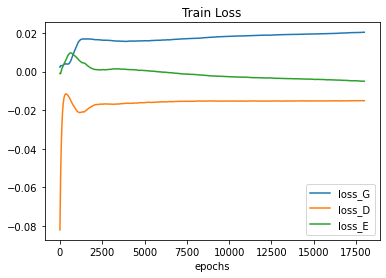

In [38]:
model = BATM(bow_dim=voc_size,
             n_topic=n_topic,
             device=device, 
             taskname=taskname)
model.train(train_data=docSet,
            batch_size=512,
            test_data=docSet,
            num_epochs=num_epochs,
            log_every=10,
            n_critic=10)

In [39]:
model.evaluate(test_data=docSet)

topic diversity:0.4311111111111111
c_v:0.6305319932021554, c_w2v:0.36150407791137695, c_uci:-12.09903473409766, c_npmi:-0.4373919284326019
mimno topic coherence:-371.03261325813844


(0.6305319932021554,
 0.36150408,
 -12.09903473409766,
 -0.4373919284326019,
 -371.03261325813844,
 0.4311111111111111)

Show words by topic number:

In [ ]:
model.show_topic_words(topic_id=1, topK=15)

[['oil',
  'low',
  'iraq',
  'refund',
  'wide',
  'russia',
  'nj',
  'world',
  'stance',
  'center',
  'general',
  'screening',
  'containment',
  'unlike',
  'alarm']]